# Inception Architecture

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

### Inception model

In [3]:
kernel_init = glorot_uniform()
bias_init = constant(value=0.2)


def inception_module(x, filter_1x1, filter_3x3_reduce, filter_3x3, filter_5x5_reduce, filter_5x5, filters_pool_proj,
                     name=None):
    conv_1x1 = Conv2D(filter_1x1, kernel_size=(1, 1), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(x)
    # 3x3 layer
    conv_3x3_reduce = Conv2D(filter_3x3_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filter_3x3, kernel_size=(3, 3), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_3x3_reduce)
    # 5x5 layer
    conv_5x5_reduce = Conv2D(filter_5x5_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filter_5x5, kernel_size=(5, 5), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_5x5_reduce)
    # pool projection layer
    pool_proj = MaxPooling2D(pool_size=(3, 3), padding='same', strides=(1, 1))(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1, 1), padding='same', activation=relu,
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output


# bottom layer
input_layer = Input(shape=(56, 56, 3))
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu,
           kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation=relu,
           kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=relu,
           kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = BatchNormalization()(x)

# inception layers
x = inception_module(x, filter_1x1=64, filter_3x3_reduce=96, filter_3x3=128, filter_5x5_reduce=16, filter_5x5=32,
                     filters_pool_proj=32, name='inception_3a')
x = inception_module(x, filter_1x1=128, filter_3x3_reduce=128, filter_3x3=192, filter_5x5_reduce=32, filter_5x5=96,
                     filters_pool_proj=64, name='inception_3b')
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_3_3x3/2')(x)

x = inception_module(x, filter_1x1=192, filter_3x3_reduce=96, filter_3x3=208, filter_5x5_reduce=16, filter_5x5=48,
                     filters_pool_proj=64, name='inception_4a')
x = inception_module(x, filter_1x1=160, filter_3x3_reduce=112, filter_3x3=224, filter_5x5_reduce=24, filter_5x5=64,
                     filters_pool_proj=64, name='inception_4b')
x = inception_module(x, filter_1x1=128, filter_3x3_reduce=128, filter_3x3=256, filter_5x5_reduce=24, filter_5x5=64,
                     filters_pool_proj=64, name='inception_4c')
x = inception_module(x, filter_1x1=112, filter_3x3_reduce=144, filter_3x3=288, filter_5x5_reduce=32, filter_5x5=64,
                     filters_pool_proj=64, name='inception_4d')
x = inception_module(x, filter_1x1=256, filter_3x3_reduce=160, filter_3x3=320, filter_5x5_reduce=32, filter_5x5=128,
                     filters_pool_proj=128, name='inception_4e')
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_4_3x3/2')(x)

x = inception_module(x, filter_1x1=256, filter_3x3_reduce=160, filter_3x3=320, filter_5x5_reduce=32, filter_5x5=128,
                     filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filter_1x1=384, filter_3x3_reduce=192, filter_3x3=384, filter_5x5_reduce=48, filter_5x5=128,
                     filters_pool_proj=128, name='inception_5b')

# classifier
x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid')(x)
x = Flatten()(x)
x = Dropout(rate=0.4)(x)
# change #1
x = Dense(units=1024, activation=relu)(x)
x = Dropout(rate=0.4)(x)
output_layer = Dense(units=37, activation=sigmoid)(x)

exp_conv = Model(input_layer, output_layer)

exp_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 56, 56, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 28, 28, 64)  0           ['conv2d_57[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 28, 28, 64)  256         ['max_pool_1_3x3/2[0][0]']   

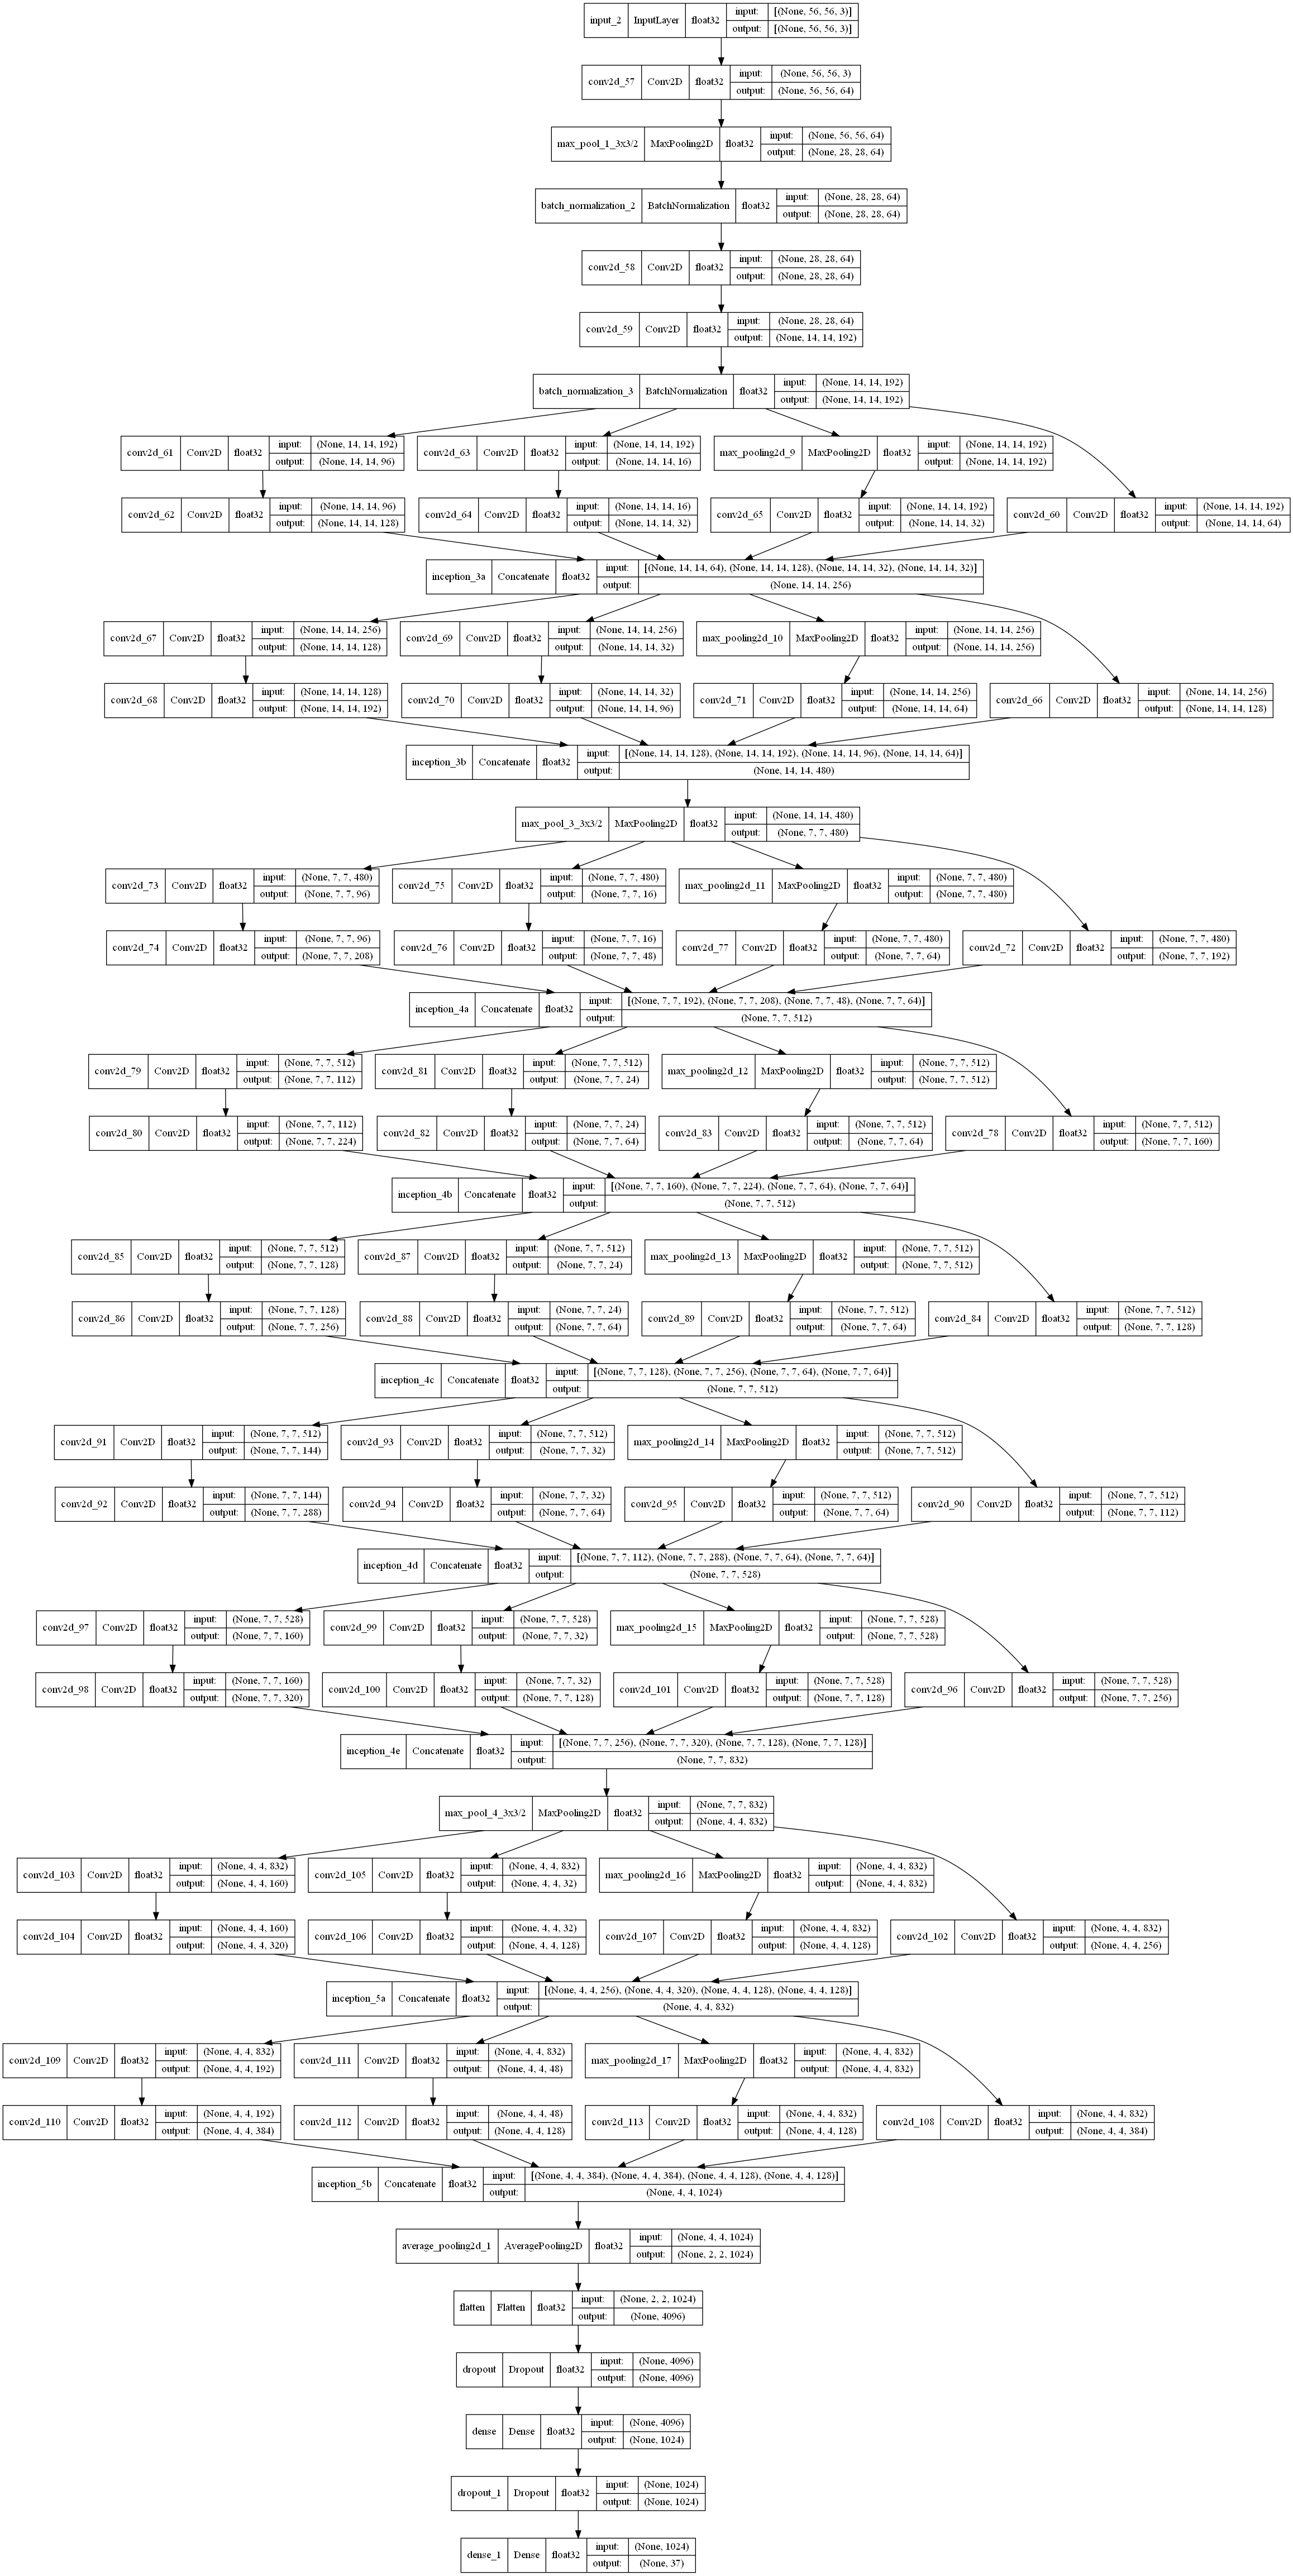

In [4]:
plot_model(model=exp_conv,
           to_file='Inception.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [5]:
tree_types = os.listdir('../../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    if not tree == 'Cassava':
        tree_path = os.path.join('../../data/image data/train', tree)
        tree_disease_types = os.listdir(tree_path)

        for disease in tree_disease_types:
            img_name = os.listdir(os.path.join(tree_path, disease))

            for img in img_name:
                image_path = os.path.join(tree_path, disease, img)
                image = img_to_array(load_img(image_path, target_size=(56, 56)))
                X.append(image)
                y.append([tree, disease])

for tree in tree_types:
    if not tree == 'Cassava':
        tree_path = os.path.join('../../data/image data/validation', tree)
        tree_disease_types = os.listdir(tree_path)

        for disease in tree_disease_types:
            img_name = os.listdir(os.path.join(tree_path, disease))

            for img in img_name:
                image_path = os.path.join(tree_path, disease, img)
                image = img_to_array(load_img(image_path, target_size=(56, 56)))
                val_x.append(image)
                val_y.append([tree, disease])


In [6]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [7]:
X.shape, y.shape, val_x.shape, val_y.shape

((36531, 56, 56, 3), (36531, 37), (9112, 56, 56, 3), (9112, 37))

In [8]:
train_gen = generator.flow(X, y, batch_size=96)
val_gen = generator.flow(val_x, val_y, batch_size=96)

#### training

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1)

check_point = ModelCheckpoint(filepath='Inception.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stopping]

In [10]:
exp_conv.compile(optimizer=Adam(),
                 loss=binary_crossentropy,
                 metrics=['accuracy'])

In [11]:
exp_conv_history = exp_conv.fit(train_gen,
                                epochs=200,
                                callbacks=callbacks,
                                validation_data=val_gen)

Epoch 1/200
381/381 [==============================] - 215s 528ms/step - loss: 0.1382 - accuracy: 0.2206 - val_loss: 0.2614 - val_accuracy: 0.1317 - lr: 0.0010
Epoch 2/200
381/381 [==============================] - 203s 533ms/step - loss: 0.0711 - accuracy: 0.3350 - val_loss: 0.0487 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 3/200
381/381 [==============================] - 209s 548ms/step - loss: 0.0436 - accuracy: 0.3725 - val_loss: 0.0374 - val_accuracy: 0.4242 - lr: 0.0010
Epoch 4/200
381/381 [==============================] - 211s 554ms/step - loss: 0.0312 - accuracy: 0.3914 - val_loss: 0.0264 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 5/200
381/381 [==============================] - 211s 554ms/step - loss: 0.0249 - accuracy: 0.4015 - val_loss: 0.0195 - val_accuracy: 0.3842 - lr: 0.0010
Epoch 6/200
381/381 [==============================] - 207s 544ms/step - loss: 0.0200 - accuracy: 0.4027 - val_loss: 0.0409 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 7/200
381/381 [===================

KeyboardInterrupt: 

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(exp_conv_history.history['loss'])))

sns.lineplot(x=epochs, y=exp_conv_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('Inception_train_history.png')
plt.show()

In [ ]:
figure_1, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=exp_conv_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=exp_conv_history.history['lr'], y=exp_conv_history.history['val_accuracy'], ax=axes[1],
             label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('VGGNet_base_conv_lr_history.png')
plt.show()